<a href="https://www.kaggle.com/code/shekharbanerjee/skb-quora-question-pairs?scriptVersionId=180951264" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/question-pairs-dataset/questions.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk , string

import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

nltk.download('wordnet')

from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/kaggle/input/question-pairs-dataset/questions.csv')

In [4]:
df.shape

(404351, 6)

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.drop(['id'],axis=1,inplace=True)

In [7]:
df['is_duplicate'].value_counts(normalize=True)

is_duplicate
0    0.630752
1    0.369248
Name: proportion, dtype: float64

In [8]:
df['is_duplicate'].value_counts()

is_duplicate
0    255045
1    149306
Name: count, dtype: int64

In [9]:
df = pd.concat([df[df['is_duplicate'] == 1].sample(frac = 0.1) ,df[df['is_duplicate'] == 0].sample(frac = 0.05)],axis=0).sample(frac=1)

In [10]:
df.shape

(27683, 5)

In [11]:
df['is_duplicate'].value_counts(normalize=True)

is_duplicate
1    0.539356
0    0.460644
Name: proportion, dtype: float64

<Axes: xlabel='is_duplicate'>

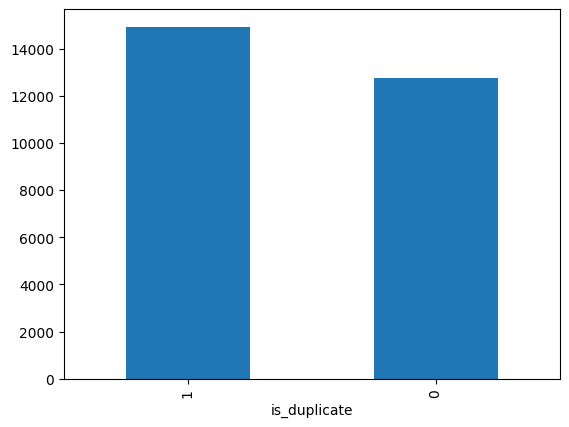

In [12]:
df['is_duplicate'].value_counts().plot(kind='bar')

**The dataset is imbalanced**  
But as the adatset is large , we can handle this by splitting dataset in a stratified fashion

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27683 entries, 270863 to 365903
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   qid1          27683 non-null  int64 
 1   qid2          27683 non-null  int64 
 2   question1     27683 non-null  object
 3   question2     27683 non-null  object
 4   is_duplicate  27683 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.3+ MB


In [14]:
df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
df.dropna(inplace=True)

In [16]:
df.isnull().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [17]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions : ',np.unique(qid).shape[0])
x = qid.duplicated()
print('Number of questions getting repeated : ',x.sum())

Number of unique questions :  55240
Number of questions getting repeated :  126


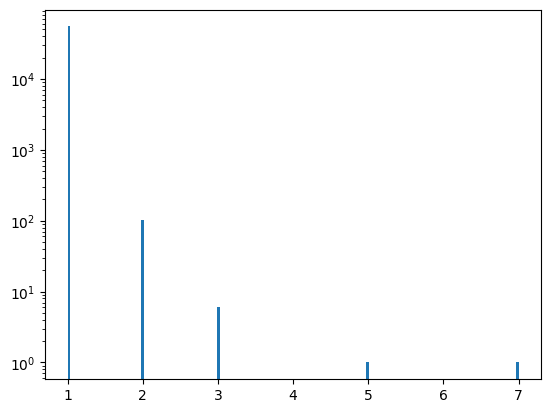

In [18]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [19]:
df.sample(20)

,qid1,qid2,question1,question2,is_duplicate
50576,100671,100672,What is the meaning of forward integration?,What is forward integration?,1
63061,125411,125412,What are some examples of kinetic energy?,What does kinetic energy consist of?,0
270006,531071,531072,What is the 80/20 rule in troubleshooting?,What is the 80/20 rule?,0
66822,132855,132856,Female virgin speaking- Is sex really as good ...,Who enjoys more sex men or women?,0
41898,83448,83449,I have an untreatable and life-long disabling ...,"What is the cheapest, easiest, least painful w...",1
13648,27248,27249,"What are the economics of the top, most exclus...",Nightlife: How do I get on the guest list for ...,0
18904,37720,37721,Are NFL games rigged?,Do you think that NFL games are rigged/fixed?,1
349809,685318,685319,"Besides Army Rangers, Green Berets, and Navy S...",Which one of these two should I Consider to jo...,0
358739,702503,702504,I recently divorced my wife and moved. Ever si...,I fear my wife will harm our young child if I ...,0
239477,471712,471713,How long will it take for me to master the Had...,Why is gold going down after Trump despite exp...,0


### Steps for going ahead with the data :

1. Preprocessing
    * Remove Punctuation
    * Remove stopwords
    * Remove contractions


In [20]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [21]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [22]:
df.head(20)

,qid1,qid2,question1,question2,is_duplicate
270863,532725,532726,is writing a letter to my ex needy,a depressed ex hurt me emotionally i wrote hi...,0
209583,413410,413411,how do i make money with youtube,how can you make money on youtube,1
241378,475441,475442,what is the secret of keeping a successful lon...,how are long distance relationships maintained,1
298443,586195,586196,why do some special forces use bow and arrows,do special forces use bow and arrows,1
68721,136602,136603,what do you do when you can not sleep,what should i do when i cannot sleep,1
126505,250631,250632,what is the future for a petroleum engineering...,is the petroleum engineering major still worth...,1
271451,533865,533866,which joystick works with moto g4 plus,does moto g4 plus support volte,0
212970,420002,420003,what is the craziest thing you have found at a...,what is the coolest weirdest most valuable t...,1
381759,746592,746593,how can i overcome my fear of change i have a...,how do i cope up with a situation when i know ...,0
252950,497965,497966,is it better for an iphone se battery to stop ...,does a phone charger really stop charging when...,0


In [23]:
df['q1_len'] = df['question1'].apply(lambda x : len(x.split()))
df['q2_len'] = df['question2'].apply(lambda x : len(x.split()))

In [24]:
df['q1_num_words'] = df['question1'].apply(lambda x : len(x.split(' ')))
df['q2_num_words'] = df['question2'].apply(lambda x : len(x.split(' ')))

In [25]:
def common_words(row):
    
    w1 = set(row['question1'].split(' '))
    w2 = set(row['question2'].split(' '))
    
    return len(w1 & w2)
    

In [26]:
df['common_words'] = df.apply(common_words, axis=1)

In [27]:
df.head(10)

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words
270863,532725,532726,is writing a letter to my ex needy,a depressed ex hurt me emotionally i wrote hi...,0,8,19,9,21,5
209583,413410,413411,how do i make money with youtube,how can you make money on youtube,1,7,7,7,7,4
241378,475441,475442,what is the secret of keeping a successful lon...,how are long distance relationships maintained,1,11,6,11,6,2
298443,586195,586196,why do some special forces use bow and arrows,do special forces use bow and arrows,1,9,7,9,7,7
68721,136602,136603,what do you do when you can not sleep,what should i do when i cannot sleep,1,9,8,9,8,4
126505,250631,250632,what is the future for a petroleum engineering...,is the petroleum engineering major still worth...,1,13,18,14,19,7
271451,533865,533866,which joystick works with moto g4 plus,does moto g4 plus support volte,0,7,6,7,6,3
212970,420002,420003,what is the craziest thing you have found at a...,what is the coolest weirdest most valuable t...,1,17,16,17,18,10
381759,746592,746593,how can i overcome my fear of change i have a...,how do i cope up with a situation when i know ...,0,26,25,28,25,9
252950,497965,497966,is it better for an iphone se battery to stop ...,does a phone charger really stop charging when...,0,24,13,24,13,8


In [28]:
def total_words(row):
    
    w1 = len(row['question1'].split(' '))
    w2 = len(row['question2'].split(' '))
    
    return w1 + w2

In [29]:
df['total_words'] = df.apply(total_words, axis=1)

In [30]:
df['word_share'] = round(df['common_words']/df['total_words'],2)

In [31]:
def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words('english')
    
    token_features = [0.0] * 8
    
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0 :
        return token_features
    
    # Non stopwords
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Stopwords
    
    q1_stopwords = set([word for word in q1_tokens if word  in STOP_WORDS])
    q2_stopwords = set([word for word in q2_tokens if word  in STOP_WORDS])
    
    
    # Common Word Count
    
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Common Stopword Count
    
    common_stopword_count = len(q1_stopwords.intersection(q2_stopwords))
    
    # Get the common Tokens from Question pair
    
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words) , len(q2_words))+ SAFE_DIV) 
    token_features[1] = common_word_count / (max(len(q1_words) , len(q2_words))+ SAFE_DIV)
    token_features[2] = common_stopword_count / (min(len(q1_stopwords) , len(q2_stopwords))+ SAFE_DIV)
    token_features[3] = common_stopword_count / (max(len(q1_stopwords) , len(q2_stopwords))+ SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens) , len(q2_tokens))+ SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens) , len(q2_tokens)) + SAFE_DIV)
    
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    
    return token_features
    
    
    

In [32]:
token_features = df.apply(fetch_token_features,axis=1)

df['cwc_min'] = list(map(lambda x : x[0] , token_features))
df['cwc_max'] = list(map(lambda x : x[1] , token_features))
df['csc_min'] = list(map(lambda x : x[2] , token_features))
df['csc_max'] = list(map(lambda x : x[3] , token_features))
df['ctc_min'] = list(map(lambda x : x[4] , token_features))
df['ctc_max'] = list(map(lambda x : x[5] , token_features))
df['last_word_eq'] = list(map(lambda x : x[6] , token_features))
df['first_word_eq'] = list(map(lambda x : x[7] , token_features))

In [33]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
270863,532725,532726,is writing a letter to my ex needy,a depressed ex hurt me emotionally i wrote hi...,0,8,19,9,21,5,30,0.17,0.499988,0.222220,0.499988,0.249997,0.499994,0.210525,0,0
209583,413410,413411,how do i make money with youtube,how can you make money on youtube,1,7,7,7,7,4,14,0.29,0.999967,0.999967,0.249994,0.249994,0.571420,0.571420,1,1
241378,475441,475442,what is the secret of keeping a successful lon...,how are long distance relationships maintained,1,11,6,11,6,2,17,0.12,0.499988,0.333328,0.000000,0.000000,0.333328,0.181817,0,0
298443,586195,586196,why do some special forces use bow and arrows,do special forces use bow and arrows,1,9,7,9,7,7,16,0.44,0.999980,0.999980,0.999950,0.499988,0.999986,0.777769,1,0
68721,136602,136603,what do you do when you can not sleep,what should i do when i cannot sleep,1,9,8,9,8,4,17,0.24,0.999900,0.499975,0.599988,0.499992,0.499994,0.444440,1,1


In [34]:
! pip install Distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=f163e7f2bee0052cd2b4568549599bc8b28c065fe61d84abf46d50598d63cb6a
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance


In [35]:

import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1) if strs else 0
    
    return length_features
    

In [36]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [37]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
270863,532725,532726,is writing a letter to my ex needy,a depressed ex hurt me emotionally i wrote hi...,0,8,19,9,21,5,...,0.222220,0.499988,0.249997,0.499994,0.210525,0,0,11,13.5,0.277778
209583,413410,413411,how do i make money with youtube,how can you make money on youtube,1,7,7,7,7,4,...,0.999967,0.249994,0.249994,0.571420,0.571420,1,1,0,7.0,0.363636
241378,475441,475442,what is the secret of keeping a successful lon...,how are long distance relationships maintained,1,11,6,11,6,2,...,0.333328,0.000000,0.000000,0.333328,0.181817,0,0,5,8.5,0.574468
298443,586195,586196,why do some special forces use bow and arrows,do special forces use bow and arrows,1,9,7,9,7,7,...,0.999980,0.999950,0.499988,0.999986,0.777769,1,0,2,8.0,0.918919
68721,136602,136603,what do you do when you can not sleep,what should i do when i cannot sleep,1,9,8,9,8,4,...,0.499975,0.599988,0.499992,0.499994,0.444440,1,1,1,8.5,0.243243


In [38]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [39]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
270863,532725,532726,is writing a letter to my ex needy,a depressed ex hurt me emotionally i wrote hi...,0,8,19,9,21,5,...,0.210525,0,0,11,13.5,0.277778,34,51,32,58
209583,413410,413411,how do i make money with youtube,how can you make money on youtube,1,7,7,7,7,4,...,0.571420,1,1,0,7.0,0.363636,77,75,74,81
241378,475441,475442,what is the secret of keeping a successful lon...,how are long distance relationships maintained,1,11,6,11,6,2,...,0.181817,0,0,5,8.5,0.574468,54,70,54,57
298443,586195,586196,why do some special forces use bow and arrows,do special forces use bow and arrows,1,9,7,9,7,7,...,0.777769,1,0,2,8.0,0.918919,89,94,89,100
68721,136602,136603,what do you do when you can not sleep,what should i do when i cannot sleep,1,9,8,9,8,4,...,0.444440,1,1,1,8.5,0.243243,79,78,66,88


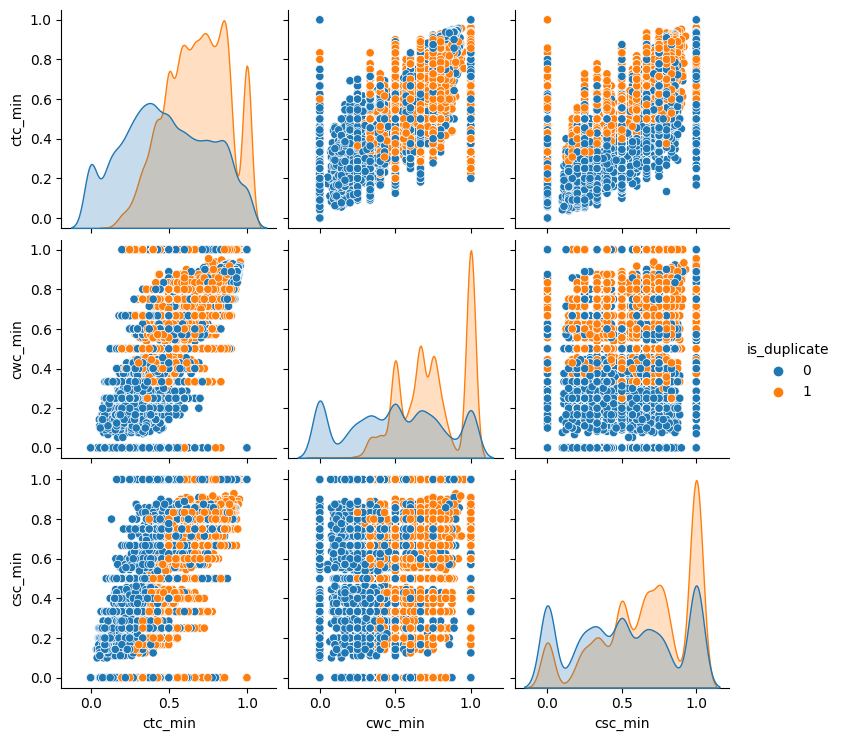

In [40]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

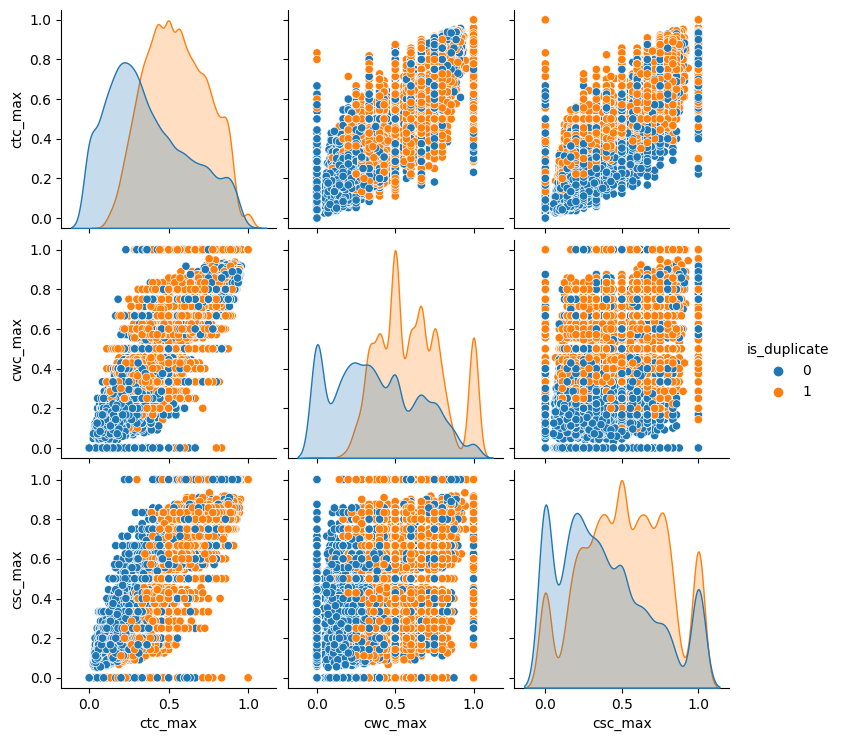

In [41]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

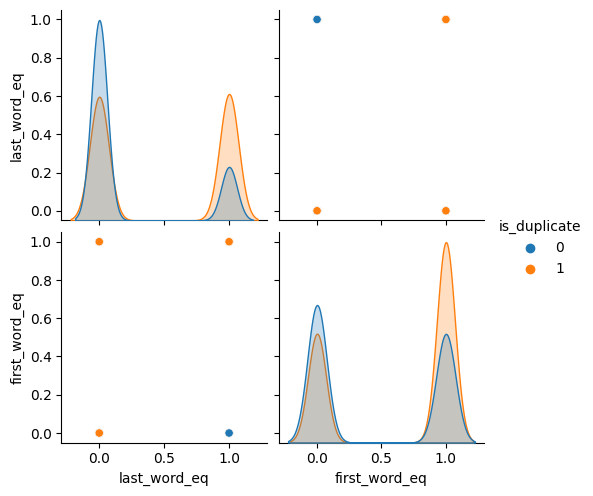

In [42]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

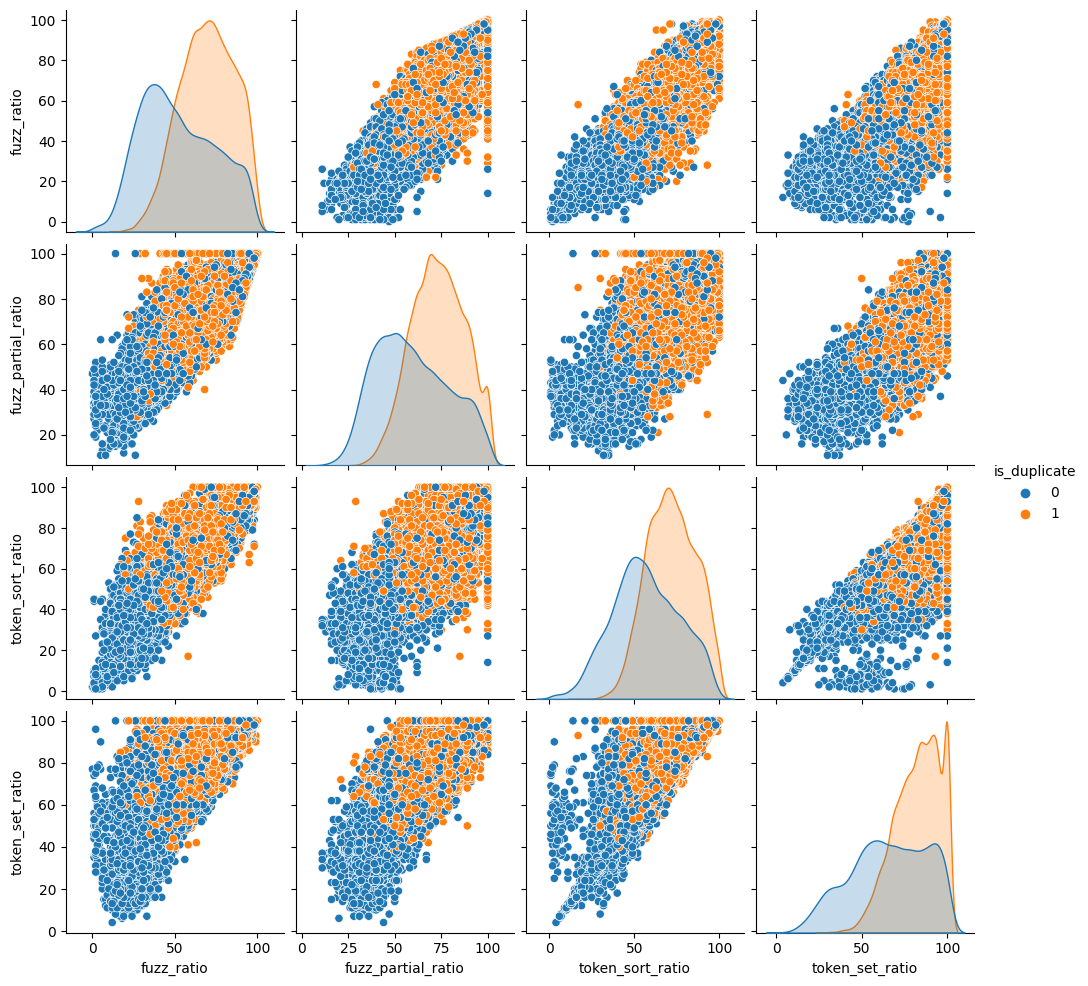

In [43]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

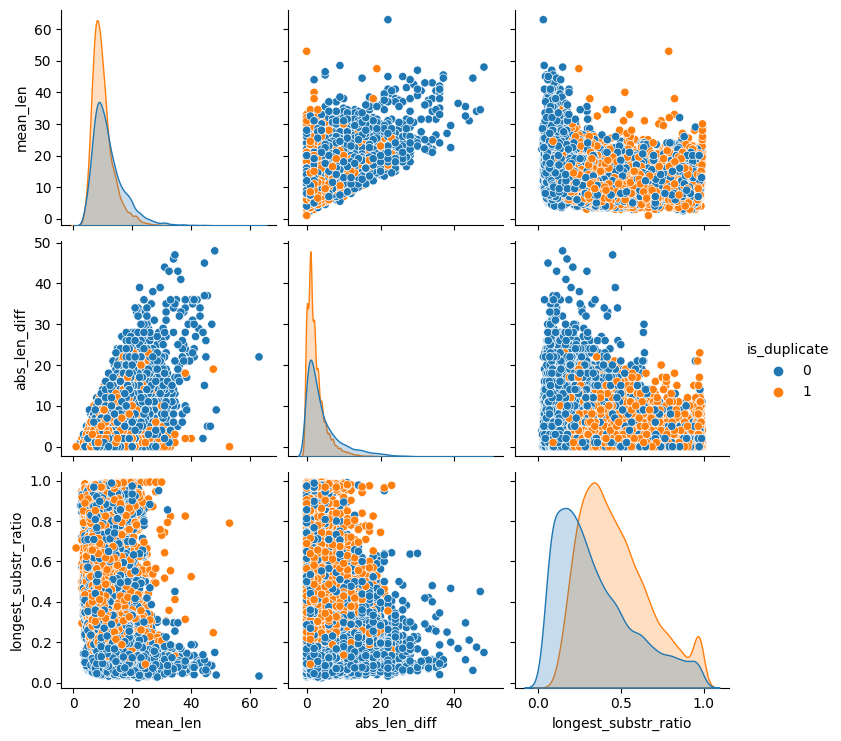

In [44]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

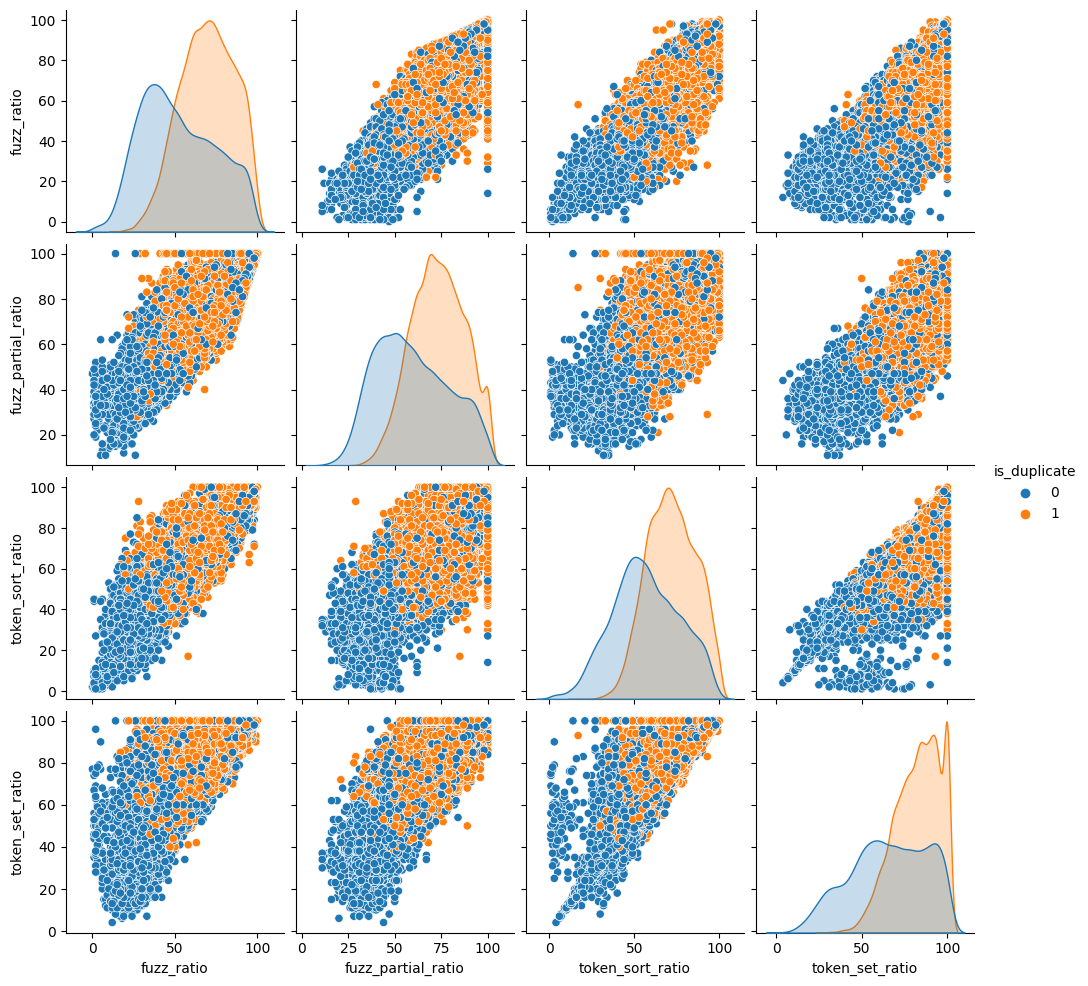

In [45]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

# merge texts
questions = list(df['question1']) + list(df['question2'])

cv = TfidfVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [47]:
df = df.drop(['question1', 'question2','qid1','qid2'],axis=1)

final_df = pd.concat([df, pd.DataFrame(q1_arr, index=df.index), pd.DataFrame(q2_arr, index= df.index)], axis=1)
print(final_df.shape)
final_df.head()

(27683, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
270863,0,8,19,9,21,5,30,0.17,0.499988,0.222220,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
209583,1,7,7,7,7,4,14,0.29,0.999967,0.999967,...,0.0,0.287906,0.0,0.0,0.0,0.0,0.586361,0.0,0.0,0.0
241378,1,11,6,11,6,2,17,0.12,0.499988,0.333328,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
298443,1,9,7,9,7,7,16,0.44,0.999980,0.999980,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
68721,1,9,8,9,8,4,17,0.24,0.999900,0.499975,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [48]:
del questions , q1_arr , q2_arr , df

In [49]:
final_df.columns = [str(i) for i in final_df.columns]
X = final_df.drop(['is_duplicate'],axis=1)
y = final_df['is_duplicate']


In [50]:
del final_df

In [51]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [52]:
y_train.value_counts()


is_duplicate
1    10427
0     8951
Name: count, dtype: int64

In [53]:
X_train.shape

(19378, 6022)

In [54]:
X_train.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,csc_min,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
72977,12,7,13,7,6,20,0.30,0.666644,0.499988,0.999975,...,0.0,0.219916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326545,12,15,12,15,8,27,0.30,0.714276,0.624992,0.749981,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178786,14,13,14,13,1,27,0.04,0.000000,0.000000,0.166664,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337651,6,5,6,5,3,11,0.27,0.749981,0.749981,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51648,24,17,25,18,7,43,0.16,0.099999,0.090908,0.833319,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7921733895243829

In [56]:

from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train.values,y_train.values)
y_pred1 = xgb.predict(X_test.values)
accuracy_score(y_test.values,y_pred1)

0.7956652618904274

In [57]:
from sklearn.metrics import confusion_matrix , classification_report

In [58]:
# for random forest model
confusion_matrix(y_test,y_pred)

array([[2486, 1315],
       [ 411, 4093]])

In [59]:
# for xgboost model
confusion_matrix(y_test,y_pred1)

array([[2596, 1205],
       [ 492, 4012]])

In [60]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      3801
           1       0.76      0.91      0.83      4504

    accuracy                           0.79      8305
   macro avg       0.81      0.78      0.78      8305
weighted avg       0.80      0.79      0.79      8305



In [61]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.84      0.68      0.75      3801
           1       0.77      0.89      0.83      4504

    accuracy                           0.80      8305
   macro avg       0.80      0.79      0.79      8305
weighted avg       0.80      0.80      0.79      8305



In [62]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)


def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [63]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [64]:

q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of Pakistan?'
q4 = 'What is the business capital of India?'


In [65]:
xgb.predict(query_point_creator(q2,q3))

array([1])

In [66]:
xgb.predict(query_point_creator(q2,q4))

array([1])

In [67]:
xgb.predict(query_point_creator(q1,q4))

array([1])

In [68]:
xgb.predict(query_point_creator(q2,q3))

array([1])

In [69]:
xgb.predict(query_point_creator('This tastes good','its tasting good'))

array([1])

In [70]:

import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))